# Max-min fairness

In this notebook, we evaluate the impact of splitting larger optimization problems into smaller sub-problems on policy runtime and quality of solution for max-min fairness policies.

## Import statements

In [2]:
import sys; sys.path.append("../../..")
from job_id_pair import JobIdPair
import utils
from plotting_utils import plot_runtimes, plot_effective_throughput_ratios
from plotting_utils import plot_runtime_vs_effective_throughput_ratios
from plotting_utils import plot_runtime_vs_effective_throughput_ratios_generic

import copy
import numpy as np
import random
import time

from partition_entities import split_generic, compute_precluster
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

## Harness that runs a policy with the passed-in number of sub-clusters

In [3]:
def create_problem_instance(num_jobs, cluster_spec,
                            policy_name,
                            seed,
                            introduce_skew=False):
    oracle_throughputs = utils.read_all_throughputs_json_v2("../../../simulation_throughputs.json")
    rng = random.Random()
    rng.seed(seed)
    jobs = {}
    throughputs = {}
    scale_factors = {}
    priority_weights = {}
    heavy_job_ids = rng.sample(range(0,num_jobs), min(num_jobs,32))
    #weights = np.random.zipf(2, num_jobs)*512
    #plt.hist(weights, bins=50)
    #plt.show()
    for i in range(num_jobs):
        job_id = JobIdPair(i, None)
        job = utils.generate_job(throughputs=oracle_throughputs,
                                 rng=rng, job_id=job_id)
        jobs[job_id[0]] = job
        job_type_key = (job.job_type, job.scale_factor)
        throughputs[job_id] = {}
        for worker_type in cluster_spec:
            throughputs[job_id][worker_type] = \
                oracle_throughputs[worker_type][job_type_key]['null']
        scale_factors[job_id] = 1
        priority_weights[job_id] = 1.0
        if introduce_skew:
            #scale_factors[job_id] = weights[i]
            #priority_weights[job_id] = weights[i]
            #priority_weights[job_id] = (i % 4) + 1.0
            if (i in heavy_job_ids):
                #print("created big job")
                scale_factors[job_id] = 512
                priority_weights[job_id] = 512
        
    if 'pack' in policy_name:
        for i in range(num_jobs):
            job_type_key = (jobs[i].job_type, jobs[i].scale_factor)
            for j in range(num_jobs):
                if i < j and jobs[i].scale_factor == jobs[j].scale_factor:
                    other_job_type_key = \
                        (jobs[j].job_type, jobs[j].scale_factor)
                    throughputs[JobIdPair(i, j)] = {}
                    for worker_type in cluster_spec:
                        throughputs[JobIdPair(i, j)][worker_type] = \
                            oracle_throughputs[worker_type][job_type_key][other_job_type_key]
    return throughputs, scale_factors, priority_weights

In [4]:
def harness(policy, throughputs, scale_factors, priority_weights, cluster_spec, num_sub_clusters=1,
            random_cluster_assignment=False, split_generic=False, split_method='means'):
    start_time = time.time()
    sub_cluster_throughputs = []
    sub_cluster_scale_factors = []
    sub_cluster_priority_weights = []
    job_to_sub_cluster_assignment = {}
    job_ids = []
    for job_id in throughputs:
        if not job_id.is_pair():
            job_ids.append(job_id)
    ##        
    if split_generic:
        job_to_sub_cluster_assignment = split_generic_wrapper(job_ids, throughputs, scale_factors, 
                                                              priority_weights, num_sub_clusters,
                                                              method=split_method,
                                                              verbose=False)
    else:
    ##    
        for i, job_id in enumerate(job_ids):
            if random_cluster_assignment:
                job_to_sub_cluster_assignment[job_id[0]] = random.randint(0, num_sub_clusters-1)
            else:
                job_to_sub_cluster_assignment[job_id[0]] = job_id[0] % num_sub_clusters
    for i in range(num_sub_clusters):
        sub_cluster_throughputs.append({})
        sub_cluster_scale_factors.append({})
        sub_cluster_priority_weights.append({})
        for job_id in throughputs:
            
            if (job_to_sub_cluster_assignment[job_id[0]] == i) and (
                 not job_id.is_pair() or (job_to_sub_cluster_assignment[job_id[1]] == i)):
                sub_cluster_throughputs[-1][job_id] = copy.copy(throughputs[job_id])
                if not job_id.is_pair():
                    sub_cluster_scale_factors[-1][job_id] = scale_factors[job_id]
                    sub_cluster_priority_weights[-1][job_id] = priority_weights[job_id]
    sub_cluster_cluster_spec = {worker_type: cluster_spec[worker_type] // num_sub_clusters
                                for worker_type in cluster_spec}
    setup_time = time.time() - start_time
    full_allocation = {}
    computation_times = []
    for i in range(num_sub_clusters):
        start_time = time.time()
        if policy._name.startswith('MaxMinFairness'):
            sub_cluster_allocation = policy.get_allocation(
                sub_cluster_throughputs[i], sub_cluster_scale_factors[i],
                sub_cluster_priority_weights[i], sub_cluster_cluster_spec)
        else:
            sub_cluster_allocation = policy.get_allocation(
                sub_cluster_throughputs[i], sub_cluster_scale_factors[i],
                sub_cluster_cluster_spec)
        for job_id in sub_cluster_allocation:
            full_allocation[job_id] = sub_cluster_allocation[job_id]
        computation_times.append(time.time() - start_time - setup_time)
    return full_allocation, setup_time + max(computation_times)

In [5]:
def sweep(policy_names_and_num_sub_clusters,
          all_num_jobs,
          num_trials, introduce_skew=False,
          split_generic=False,
          split_method='means'):
    all_runtimes = {}
    all_effective_throughputs = {}
    all_high_effective_throughputs = {}
    all_low_effective_throughputs = {}
    for num_jobs in all_num_jobs:
        all_runtimes[num_jobs] = []
        all_effective_throughputs[num_jobs] = []
        all_high_effective_throughputs[num_jobs] = []
        all_low_effective_throughputs[num_jobs] = []
        cluster_spec = {
            'v100': max(num_jobs // 4, 1),
            'p100': max(num_jobs // 4, 1),
            'k80': max(num_jobs // 4, 1),
        }
        for i in range(num_trials):
            throughputs, scale_factors, priority_weights = \
                create_problem_instance(num_jobs, cluster_spec,
                                        policy_names_and_num_sub_clusters[0][0], seed=i,
                                        introduce_skew=introduce_skew)
            all_runtimes[num_jobs].append([])
            allocations = []
            for (policy_name, num_sub_clusters) in policy_names_and_num_sub_clusters:
                policy = utils.get_policy(policy_name, solver='ECOS')
                allocation, runtime = harness(
                    policy, throughputs,
                    scale_factors,
                    priority_weights,
                    cluster_spec,
                    num_sub_clusters=num_sub_clusters,
                    split_generic=split_generic,
                    split_method=split_method)
                all_runtimes[num_jobs][-1].append(runtime)
                allocations.append(allocation)

            all_effective_throughputs[num_jobs].append([])
            all_high_effective_throughputs[num_jobs].append([])
            all_low_effective_throughputs[num_jobs].append([])
            for allocation in allocations:
                effective_throughputs = {}
                high_effective_throughputs = {}
                low_effective_throughputs = {}
                for job_id in allocation:
                    for single_job_id in job_id.singletons():
                        if single_job_id not in effective_throughputs:
                            effective_throughputs[single_job_id] = 0.0
                            if priority_weights[single_job_id] > 1.0:
                                high_effective_throughputs[single_job_id] = 0.0
                            else:
                                low_effective_throughputs[single_job_id] = 0.0
                    for worker_type in allocation[job_id]:
                        if job_id.is_pair():
                            for i, single_job_id in enumerate(job_id.singletons()):
                                effective_throughputs[single_job_id] += (
                                   allocation[job_id][worker_type] *
                                   throughputs[job_id][worker_type][i]
                                )
                        else:
                            et_add = (allocation[job_id][worker_type] *
                                      throughputs[job_id][worker_type])
                            effective_throughputs[job_id] += et_add
                            if priority_weights[single_job_id] > 1.0:
                                high_effective_throughputs[job_id] += et_add
                            else:
                                low_effective_throughputs[job_id] += et_add
                all_effective_throughputs[num_jobs][-1].append(effective_throughputs)
                all_high_effective_throughputs[num_jobs][-1].append(high_effective_throughputs)
                all_low_effective_throughputs[num_jobs][-1].append(low_effective_throughputs)
    return all_runtimes, all_effective_throughputs, \
           all_high_effective_throughputs, all_low_effective_throughputs

## Effective throughputs and runtimes

In [6]:
def get_runtimes_and_effective_throughputs(policy_name, all_num_sub_clusters,
                                           num_jobs, introduce_skew=False,
                                           split_generic=False, split_method='means'):
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    #if not introduce_skew:
    #    policy_names_and_num_sub_clusters.append(
    #        ('gandiva', 1))
    all_runtimes, all_effective_throughputs, \
    all_high_effective_throughputs, all_low_effective_throughputs = sweep(
        policy_names_and_num_sub_clusters, [num_jobs],
        num_trials=1, introduce_skew=introduce_skew,
        split_generic=split_generic, split_method=split_method)
    runtimes = all_runtimes[num_jobs][0]
    all_effective_throughputs = all_effective_throughputs[num_jobs][0]
    high_effective_throughputs = all_high_effective_throughputs[num_jobs][0]
    low_effective_throughputs = all_low_effective_throughputs[num_jobs][0]
    return runtimes, all_effective_throughputs, \
            high_effective_throughputs, low_effective_throughputs

In [ ]:
import ast
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
with open('num_jobs=1024.out', 'r') as f:
    runtimes = f.readline().strip()
    runtimes = ast.literal_eval(runtimes)
    all_effective_throughputs = f.readline().strip()
    all_effective_throughputs = ast.literal_eval(all_effective_throughputs)

plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    draw_arrow=True,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=1024.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           256)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=256.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           256,
                                           introduce_skew=True)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/skewed_num_jobs=256.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           512)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=512.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           512,
                                           introduce_skew=True)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/skewed_num_jobs=512.pdf")

## Runtimes

In [ ]:
def get_runtimes(policy_name, all_num_jobs, introduce_skew=False):
    data = {
        'policy': [],
        'num_jobs': [],
        'runtimes': []
    }
    all_num_sub_clusters = [1, 4, 16]
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    policy_labels = ['Vanilla', '4 sub-clusters', '16 sub-clusters']
    all_runtimes, _ = sweep(policy_names_and_num_sub_clusters,
                            all_num_jobs,
                            num_trials=1,
                            introduce_skew=introduce_skew)
    for num_jobs in all_runtimes:
        for i in range(len(all_runtimes[num_jobs])):
            for (policy_label, runtime) in zip(
                policy_labels, all_runtimes[num_jobs][i]):
                data['policy'].append(policy_label)
                data['num_jobs'].append(num_jobs)
                data['runtimes'].append(runtime)
    return data

In [ ]:
all_num_jobs = [64, 128, 256, 512, 1024, 2048,
                4096, 8192, 16384, 32768]
xticks = [64, 512, 4096, 32768]
yticks = [2**-8, 2**-5, 2**-2, 2**1, 2**4, 2**7]
yticklabels = [0.004, 0.031, 0.25, 2, 16, 128]
plot_runtimes(get_runtimes('max_min_fairness_perf',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=False),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels,
              output_filename="runtimes/max_min_fairness_perf.pdf")
plot_runtimes(get_runtimes('max_min_fairness_perf',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=True),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels)

In [ ]:
# TODO: Increase to 1024.
all_num_jobs=[64, 128, 256, 512]
xticks = [64, 128, 256, 512]
yticks = [2**-5, 2**-2, 2**1, 2**4, 2**7]
yticklabels = [0.031, 0.25, 2, 16, 128]
plot_runtimes(get_runtimes('max_min_fairness_packed',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=False),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels,
              output_filename="runtimes/max_min_fairness_packed.pdf")
plot_runtimes(get_runtimes('max_min_fairness_packed',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=True),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels)

## Effective throughput ratios

In [ ]:
def get_effective_throughput_ratios(policy_name, num_jobs, introduce_skew=False,
                                    random_cluster_assignment=False):
    random.seed(42)
    all_num_sub_clusters = [1, 4, 16]
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    _, all_effective_throughputs = sweep(
        policy_names_and_num_sub_clusters,
        [num_jobs],
        num_trials=1,
        introduce_skew=introduce_skew)
    return all_effective_throughputs[num_jobs][0]

In [ ]:
print("No skew")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64),
    output_filename="effective_throughput_ratios/max_min_fairness_perf.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_cdf.pdf")
print("Skew and round-robin placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64,
        introduce_skew=True),
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_cdf.pdf")
print("Skew and random placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True,
                                    random_cluster_assignment=True),
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_random.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True,
                                    random_cluster_assignment=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_random_cdf.pdf")

In [ ]:
print("No skew")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64),
    output_filename="effective_throughput_ratios/max_min_fairness_packed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_cdf.pdf")
print("Skew and round-robin placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
    introduce_skew=True),
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
        introduce_skew=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_cdf.pdf")
print("Skew and random placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
         introduce_skew=True,
    random_cluster_assignment=True),
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_random.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
        introduce_skew=True,
        random_cluster_assignment=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_random_cdf.pdf")

In [7]:
# wrapper function for calling split_generic, return job to subcluster mapping
def split_generic_wrapper(job_ids_list, throughputs, scale_factors, priority_weights, num_subproblems, 
                          method='means', verbose=False):
    
    if verbose:
        print("job ids: " + str(job_ids_list))
        print("throughputs: " + str(throughputs))
        print("scale factors: " + str(scale_factors))
        print("priority weights: " + str(priority_weights))
    
    job_to_subcluster_assignment = {}
    
    # if theres only 1 subproblem, assign all entities to it and return
    if num_subproblems == 1:
        for job_id in job_ids_list:
            job_to_subcluster_assignment[job_id[0]] = 0
        return job_to_subcluster_assignment
            
    all_inputs_dict = {}
    num_resources = len(list(throughputs.values())[0])
    num_jobs = len(throughputs)
    np_data = np.zeros((num_jobs,num_resources+2))# dimensions are each resourse, scale factor, and priority
    
    # get mean of each input dimension
    scale_factors_mean = np.mean([item for item in scale_factors.values()])
    priority_mean = np.mean([item for item in priority_weights.values()])
    throughput_means = [sum([list(t.values())[i] for t in throughputs.values()])/num_jobs for i in range(num_resources)]
    
    
    # create dict mapping job id to list of features (normalized by mean of said feature)
    for i, job_id in enumerate(job_ids_list):
        throughput_dict = throughputs[job_id]
        job_input_list = [list(throughput_dict.values())[i]/throughput_means[i] for i in range(len(throughput_dict))]
        
        job_input_list.append(scale_factors[job_id]/scale_factors_mean)
        job_input_list.append(priority_weights[job_id]/priority_mean)
        all_inputs_dict[job_id[0]] = job_input_list
        np_data[i,:] = job_input_list
        
    # assign jobs to different subproblems, then create assignment dict
    precluster = None
    if method is 'cluster':
        precluster = compute_precluster(np_data, 27)
    
    subproblem_assignments = split_generic(all_inputs_dict, np_data, num_subproblems, 
                                           method=method, precluster=precluster)
    if method is 'cluster':
        # replace job id indices with job ids
        for subproblem_assignment in subproblem_assignments:
            subproblem_assignment = [job_ids_list[x] for x in subproblem_assignment]
            
    for sa in subproblem_assignments:
        print(len(sa))
    
    for i, subproblem_list in enumerate(subproblem_assignments):
        for job in subproblem_list:
            job_to_subcluster_assignment[job] = i
            
    return job_to_subcluster_assignment

In [11]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'POP-16', 'POP-32']#, 'POP-64']#,'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8, 16, 32]#, 64]
num_jobs = 2**14
runtimes_rand, all_effective_throughputs_rand,\
high_effective_throughputs_rand, low_effective_throughputs_rand = \
    get_runtimes_and_effective_throughputs('max_min_fairness',
                                           all_num_sub_clusters,
                                           num_jobs,
                                           introduce_skew=True,
                                           split_generic=False,
                                           split_method='means')
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, all_effective_throughputs, labels,
#    output_filename="effective_throughput_ratio_and_runtimes/num_jobs="+str(num_jobs)+".pdf")
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, high_effective_throughputs, labels)
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, low_effective_throughputs, labels)

runtimes_means, all_effective_throughputs_means,\
high_effective_throughputs_means, low_effective_throughputs_means = \
    get_runtimes_and_effective_throughputs('max_min_fairness',
                                           all_num_sub_clusters,
                                           num_jobs,
                                           introduce_skew=True,
                                           split_generic=True,
                                           split_method='means')
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, all_effective_throughputs, labels,
#    output_filename="effective_throughput_ratio_and_runtimes/num_jobs="+str(num_jobs)+".pdf")
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, high_effective_throughputs, labels)
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, low_effective_throughputs, labels)

runtimes_clust, all_effective_throughputs_clust,\
high_effective_throughputs_clust, low_effective_throughputs_clust = \
    get_runtimes_and_effective_throughputs('max_min_fairness',
                                           all_num_sub_clusters,
                                           num_jobs,
                                           introduce_skew=True,
                                           split_generic=True,
                                           split_method='cluster')
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, all_effective_throughputs, labels,
#    output_filename="effective_throughput_ratio_and_runtimes/num_jobs="+str(num_jobs)+".pdf")
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, high_effective_throughputs, labels)
#plot_runtime_vs_effective_throughput_ratios_generic(
#    runtimes, low_effective_throughputs, labels)



Assigned 0 entities
Assigned 4096 entities
Assigned 8192 entities
Assigned 12288 entities
8192
8192
Assigned 0 entities
Assigned 4096 entities
Assigned 8192 entities
Assigned 12288 entities
4106
4005
4137
4136
Assigned 0 entities
Assigned 4096 entities
Assigned 8192 entities
Assigned 12288 entities
2069
1976
2038
2046
2069
2062
2069
2055
Assigned 0 entities
Assigned 4096 entities
Assigned 8192 entities
Assigned 12288 entities
1035
1035
1035
1035
1035
1035
859
1035
1035
1035
1035
1035
1035
1035
1035
1035
Assigned 0 entities
Assigned 4096 entities
Assigned 8192 entities
Assigned 12288 entities
518
518
518
518
518
518
515
518
518
518
484
518
518
518
518
518
518
518
518
518
518
518
518
518
518
518
409
518
518
472
518
518
--- 0.0034029483795166016 seconds ---
8192
8192
--- 0.002565145492553711 seconds ---
4096
4096
4096
4096
--- 0.009177446365356445 seconds ---
2048
2048
2048
2048
2048
2048
2048
2048
--- 0.0035009384155273438 seconds ---
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
102

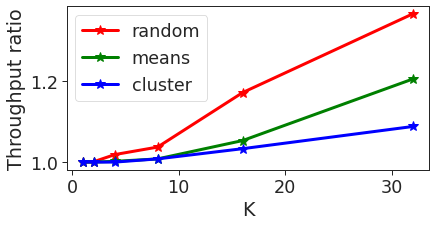

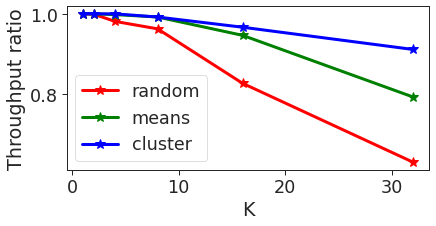

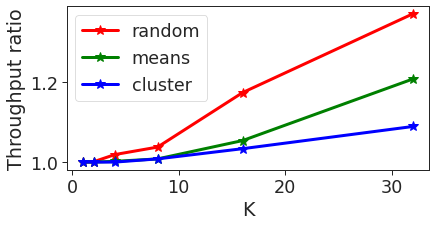

In [24]:
def comp_mean(all_effective_throughputs):
    job_ids = list(all_effective_throughputs[0].keys())
    means = []
    for effective_throughputs in all_effective_throughputs:
        effective_throughput_ratios = np.array([
            effective_throughputs[job_id] / all_effective_throughputs[0][job_id]
            for job_id in job_ids])
        mean_t = np.mean(effective_throughput_ratios)
        means.append(mean_t)
    return means

plt.figure(figsize=(6.5, 3))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax.plot(all_num_sub_clusters, comp_mean(all_effective_throughputs_rand), 'r', marker='*', label='random')
ax.plot(all_num_sub_clusters, comp_mean(all_effective_throughputs_means), 'g', marker='*', label='means')
ax.plot(all_num_sub_clusters, comp_mean(all_effective_throughputs_clust), 'b', marker='*', label='cluster')
ax.set_ylabel("Throughput ratio")
ax.set_xlabel("K")
ax.legend()

plt.figure(figsize=(6.5, 3))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax.plot(all_num_sub_clusters, comp_mean(high_effective_throughputs_rand), 'r', marker='*', label='random')
ax.plot(all_num_sub_clusters, comp_mean(high_effective_throughputs_means), 'g', marker='*', label='means')
ax.plot(all_num_sub_clusters, comp_mean(high_effective_throughputs_clust), 'b', marker='*', label='cluster')
ax.set_ylabel("Throughput ratio")
ax.set_xlabel("K")
ax.legend()

plt.figure(figsize=(6.5, 3))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax.plot(all_num_sub_clusters, comp_mean(low_effective_throughputs_rand), 'r', marker='*', label='random')
ax.plot(all_num_sub_clusters, comp_mean(low_effective_throughputs_means), 'g', marker='*', label='means')
ax.plot(all_num_sub_clusters, comp_mean(low_effective_throughputs_clust), 'b', marker='*', label='cluster')
ax.set_ylabel("Throughput ratio")
ax.set_xlabel("K")
ax.legend()